/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


1 002_0002


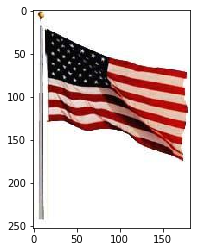

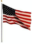

/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


2 002_0003


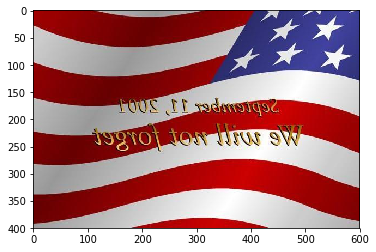

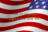

3 002_0001


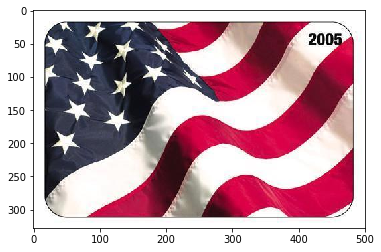

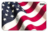

In [21]:
import os
import glob
import cv2
import numpy as np
import torch
import model 

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image

import matplotlib.pyplot as plt


imageSize = 32
upSampling = 4


model_path = 'models/RRDB_ESRGAN_x4.pth'  # the stored model

device = torch.device('cuda')  
#device = torch.device('cpu')

HR_img_folder = 'HR/*'

netG = model.RRDB_Net(3, 3, 64, 23, gc=32, upscale=4, norm_type=None, act_type='leakyrelu', res_scale=1)

netG.load_state_dict(torch.load(model_path), strict=True)
netG.eval()
for k, v in netG.named_parameters():
    v.requires_grad = False
netG = netG.to(device)

unnormalize = transforms.Normalize(mean = [-2.118, -2.036, -1.804], std = [4.367, 4.464, 4.444])

scale = transforms.Compose([transforms.ToPILImage(),
                            transforms.Scale(imageSize),
                            transforms.ToTensor(),
                            transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
                            ])


idx = 0
for path in glob.glob(HR_img_folder):
    idx += 1
    base = os.path.splitext(os.path.basename(path))[0]
    print(idx, base)
    # read image
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    low_res = scale(img[...,::-1])
    
    img = img * 1.0 / 255
    
    # original image
    plt.imshow(img[...,::-1])
    plt.show()
    
    # LR image
    to_pil = transforms.ToPILImage()
    lr_img = to_pil(unnormalize(low_res))
    display(lr_img)
    
    
    img = torch.from_numpy(np.transpose(img[:, :, [2, 1, 0]], (2, 0, 1))).float()
    img_LR = img.unsqueeze(0)
    img_LR = img_LR.to(device)

    output = netG(img_LR).data.squeeze().float().cpu().clamp_(0, 1).numpy()
    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))
    output = (output * 255.0).round()

    # store SR image
    cv2.imwrite('SR/{:s}_SR.png'.format(base), output)
 

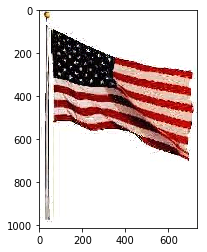

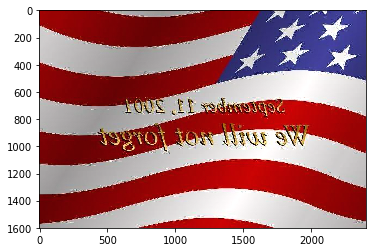

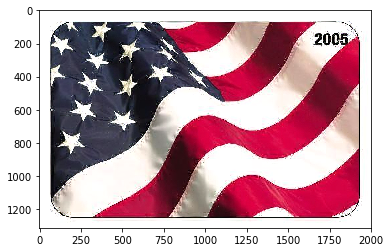

In [24]:
SR_img_folder = 'SR/*'

#SR image
for path in glob.glob(SR_img_folder)[::-1]:
    idx += 1
    base = os.path.splitext(os.path.basename(path))[0]   
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = img * 1.0 / 255
        
    plt.imshow(img[...,::-1])
    plt.show()